# AIML339 Assignment 3
## Matrix Profiles for Anomaly Detection and Time Series Dynamics

The matrix profile is primarily used to find repeating patterns and outliers in a single, univariate time series.. This is based on the principle of similarity joins - comparing a sub-sequence of the time series against itself, by computing the distance between each pair of subsequences. Matrix profile algorithms have the following properties:
- Domain agnostic
- Can be exact or approximate
- Only one hyperparameter (window length)
- Parallelizable
- Stream compatible
- Handles missing data

## Terms:
- **Motif**: A repeated pattern in the time series.
- **Discord**: An anomaly in the time series.




In [1]:
import pandas as pd
import numpy as np
import stumpy
from stumpy import config
from numba import cuda
import matplotlib.pyplot as plt
from helpers import plot_features, plot_detection, evaluate_predictions

### Load the Datasets
Datasets used:
- GenSyn (synthetic electricity prices)
- Electricity Authority Point of Connection WWD1102

In [2]:
gensyn_raw    = pd.read_csv(r"data/GenSyn2122.csv", parse_dates=[[0, 1]])
gensyn_labels = pd.read_csv(r"data/GenSyn_labels2122.csv")
poc_raw    = pd.read_csv(r"data/2024-08-10_2025-08-10_pocWWD1102_WWD1103.csv")

/tmp/ipykernel_2456/840461730.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  gensyn_raw    = pd.read_csv(r"data/GenSyn2122.csv", parse_dates=[[0, 1]])
/tmp/ipykernel_2456/840461730.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  gensyn_raw    = pd.read_csv(r"data/GenSyn2122.csv", parse_dates=[[0, 1]])


In [3]:
gensyn = pd.concat([gensyn_raw, gensyn_labels], axis=1)
gensyn["time"] = pd.to_datetime(gensyn["year_day_of_year"], format="%Y %j")
gensyn["year"] = pd.to_datetime(gensyn["year_day_of_year"], format="%Y %j").dt.strftime("%Y").astype(int)
gensyn["day_of_year"] = pd.to_datetime(gensyn["year_day_of_year"], format="%Y %j").dt.strftime("%j").astype(int)
gensyn = gensyn.rename(columns={"energy_usage": "energy", "anomaly_label": "label"})

In [4]:
poc = (poc_raw
    .where(poc_raw["PointOfConnection"] == "WWD1102")
    .groupby(["TradingDate", "TradingPeriod"], as_index=False)
    .agg({
        "DollarsPerMegawattHour": "mean"
    })[["DollarsPerMegawattHour", "TradingDate", "TradingPeriod"]]
)

# Join onto a complete list of start times (every half hour) to ensure no missing values

data_start = min(poc["TradingDate"])
data_end = max(poc["TradingDate"])

dates_df = pd.DataFrame(pd.date_range(start=data_start, end=data_end), columns=["TradingDate"])
periods = pd.DataFrame(range(1, 48+1), columns=["TradingPeriod"])
dates_df = dates_df.join(periods, how="cross")

dates_df["TradingDate"] = dates_df["TradingDate"].dt.date
poc["TradingDate"] = pd.to_datetime(poc["TradingDate"]).dt.date
poc["date_time"] = pd.to_datetime(poc["TradingDate"]) + pd.to_timedelta((poc["TradingPeriod"] - 1) * 30, unit="m")
poc = pd.merge(poc, dates_df, how="left", on=["TradingDate", "TradingPeriod"])
poc["year"] = pd.to_datetime(poc["TradingDate"], format="%Y-%m-%d").dt.strftime("%Y").astype(int)
poc["day_of_year"] = pd.to_datetime(poc["TradingDate"], format="%Y-%m-%d").dt.strftime("%j").astype(int)
poc = poc.rename(columns={"DollarsPerMegawattHour": "energy"})

poc.head()

,energy,TradingDate,TradingPeriod,date_time,year,day_of_year
0,831.943333,2024-08-10,1.0,2024-08-10 00:00:00,2024,223
1,818.933333,2024-08-10,2.0,2024-08-10 00:30:00,2024,223
2,827.310000,2024-08-10,3.0,2024-08-10 01:00:00,2024,223
3,805.053333,2024-08-10,4.0,2024-08-10 01:30:00,2024,223
4,808.931667,2024-08-10,5.0,2024-08-10 02:00:00,2024,223


In [5]:
# cuda acceleration
gpus = [device.id for device in cuda.list_devices()]

### Functions for testing & evaluating

In [90]:
def find_anomalies(df, col, windows, k=3, normalize=True, exclude_nearby=True, gpu=None, series=None):
    if series is None:
        series = df[col].values

    n = len(series)
    results = {}

    for w in windows:
        if gpu is not None:
            mp = stumpy.gpu_stump(series, m=w, device_id=gpu, normalize=normalize)
        else:
            mp = stumpy.stump(series, m=w)

        profile = mp[:, 0]

        padded_profile = np.full(n, np.nan)
        padded_profile[w-1:] = profile

        if exclude_nearby:
            anomaly_indices, anomaly_scores = topk_anomalies_with_exclusion(profile, k, w)
        else:
            anomaly_indices = np.argsort(profile)[-k:]
            anomaly_scores = profile[anomaly_indices]

        mask = np.ones(n, dtype=int)
        for idx in anomaly_indices:
            l = idx
            r = idx + w
            mask[l:r] = -1

        results[w] = {
            "profile": padded_profile,
            "indices": anomaly_indices,
            "scores": anomaly_scores,
            "mask": mask
        }

    return results

def topk_anomalies_with_exclusion(profile, k, w):
    profile = profile.copy()
    anomaly_indices = []
    anomaly_scores = []

    for _ in range(k):
        idx = np.nanargmax(profile)
        score = profile[idx]

        anomaly_indices.append(idx)
        anomaly_scores.append(score)

        l = max(0, idx - w)
        r = min(len(profile), idx + w)
        profile[l:r] = -np.inf

    return np.array(anomaly_indices), np.array(anomaly_scores)

def explanatory_plot(signal, mp, idx, title=None):

    fig, ax = plt.subplots(figsize=(12,5))

    ax.plot(signal, label="signal")
    ax.plot(mp[idx]["profile"], label="matrix profile")

    ax2 = ax.twinx()
    ax2.set_ylim(-1, 1)
    ax2.get_yaxis().set_visible(False)

    mask = mp[idx]["mask"]

    x = np.arange(len(mask))

    ax2.fill_between(x, -1, 1, where=(mask == -1),
                     color="red", alpha=0.3, label="top discords")

    fig.legend()

    if title is not None:
        fig.suptitle(title)

    return plt

## Choice of Window Size
How does changing the subsequence length (e.g., 24 hours, 48 hours, 168 hours) affect which anomalies are discovered?

First, I opted to visualise applying the matrix profile with window size `w = 7`, which is one week in this context.

In [98]:
test_norm = find_anomalies(gensyn, "energy", [7], k=3, normalize=True, exclude_nearby=True, gpu=gpus)
test_no_norm = find_anomalies(gensyn, "energy", [7], k=3, normalize=False, exclude_nearby=True, gpu=gpus)

<module 'matplotlib.pyplot' from '/home/lennoxc/aiml338/aiml338-a3/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

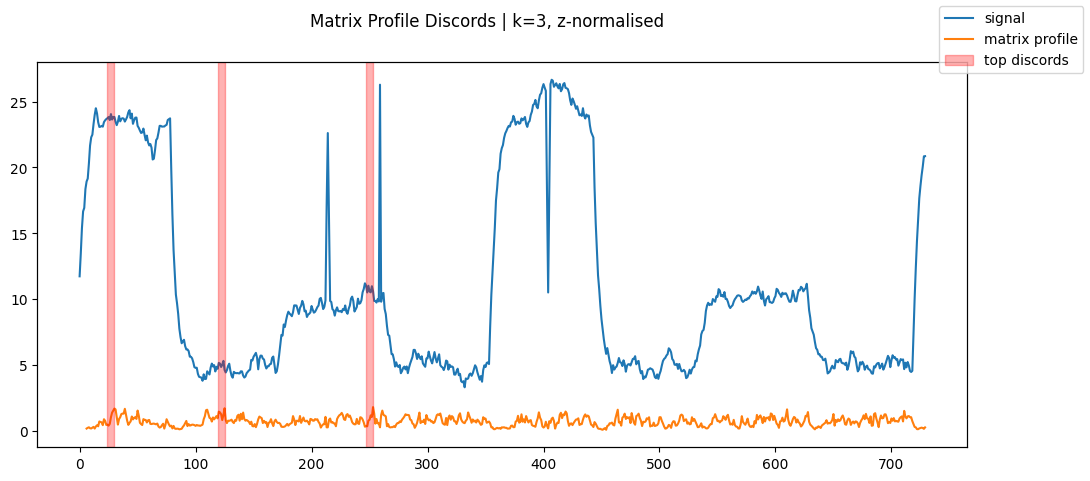

In [97]:
explanatory_plot(gensyn["energy"], test_norm, 7, title="Matrix Profile Discords | k=3, z-normalised")

<module 'matplotlib.pyplot' from '/home/lennoxc/aiml338/aiml338-a3/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

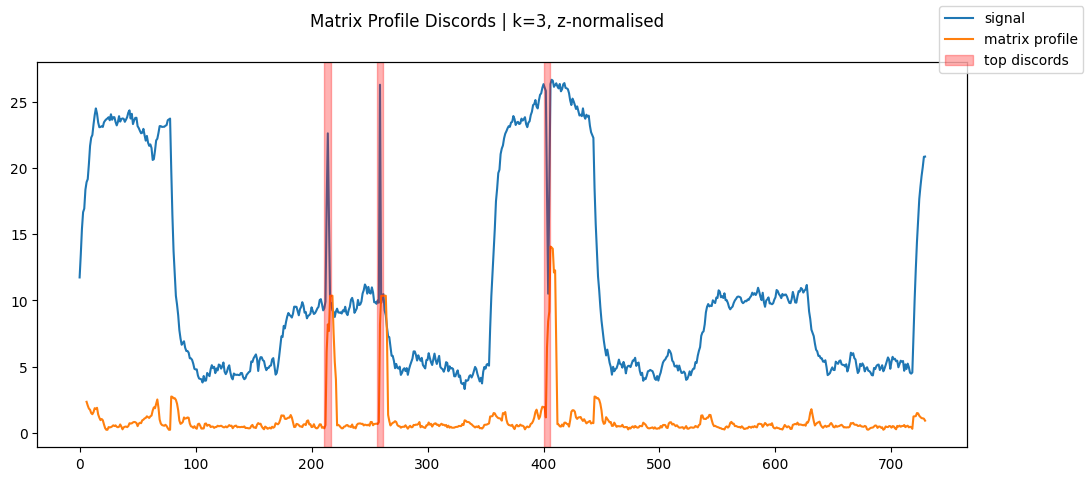

In [99]:
explanatory_plot(gensyn["energy"], test_no_norm, 7, title="Matrix Profile Discords | k=3, z-normalised")

These charts show the matrix profile alongside the original series. The matrix profile is the euclidean distance to its nearest neighbour, when placing segments of the series in `w` dimensional space.

Z-normalization will normalize subsequences prior to computing distances. This is desirable if you are wanting to find anomalous *patterns*, but not desirable if you want to find anomalous values, as the actual values of the points get normalised.

Initially, it seems that the matrix profile struggles to find anomalies in this sequence. However, after removing normalization, the anomalies are found easily.

It seems that normalisation is an important hyperparameter in the matrix profile algorithm.

### Changing the window size

In [101]:
windows = [3, 5, 7, 14, 28]

window_experiment = find_anomalies(gensyn, "energy", windows, k=3, normalize=False,  exclude_nearby=True, gpu=gpus)

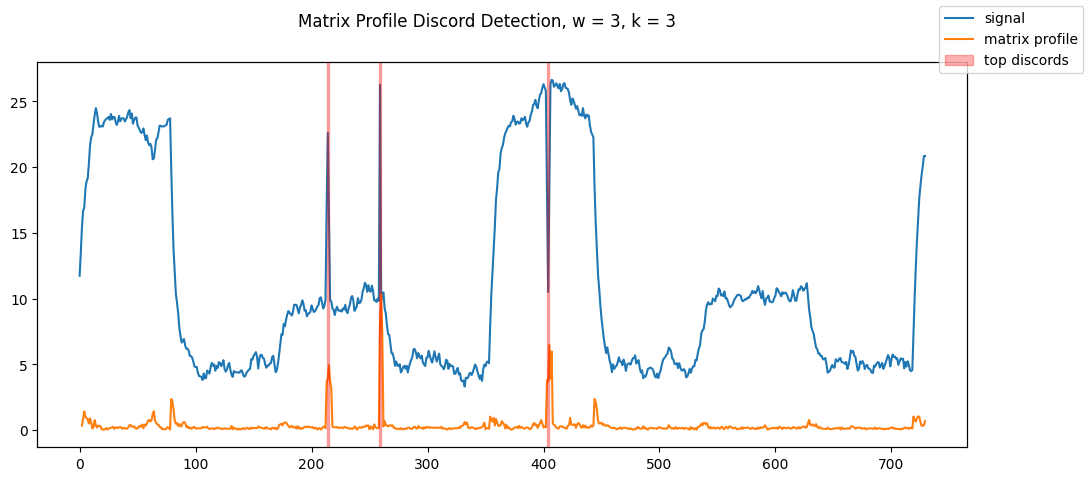

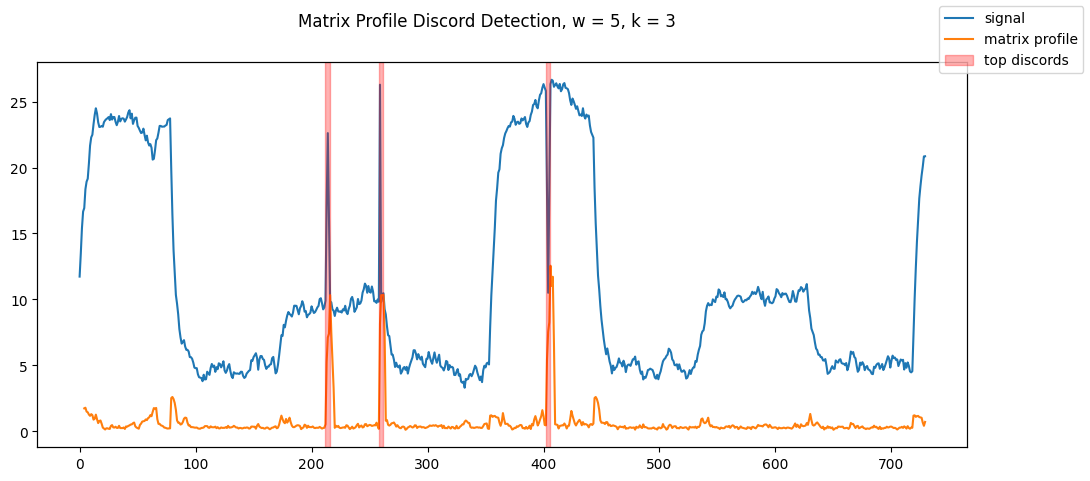

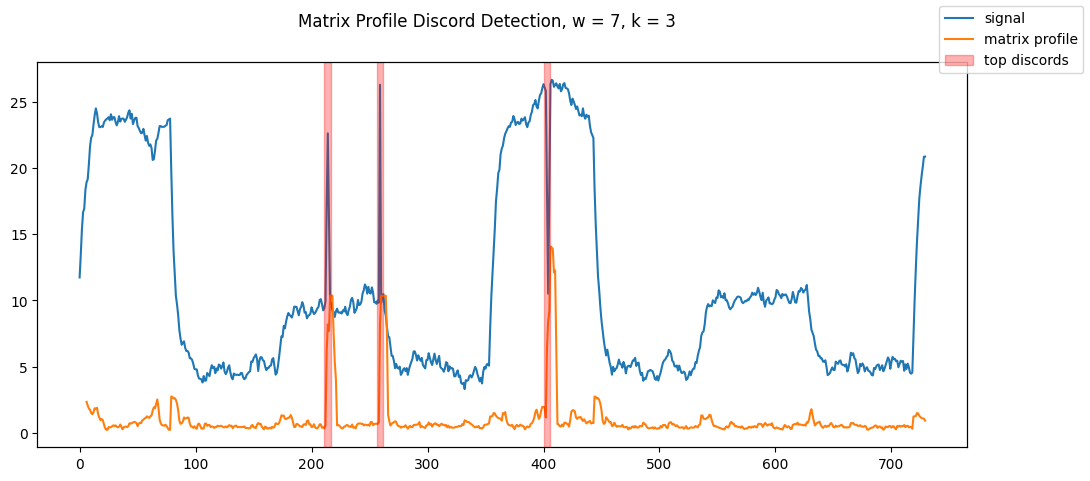

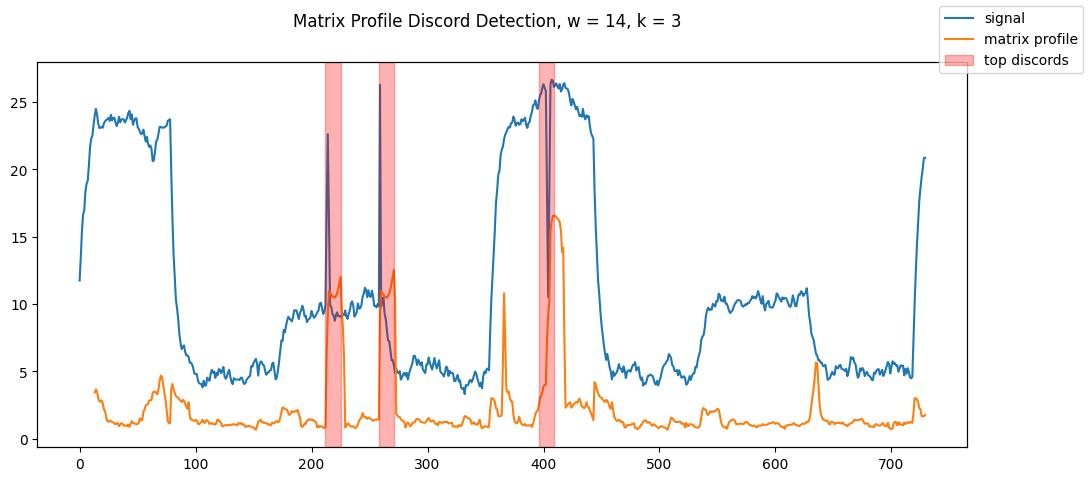

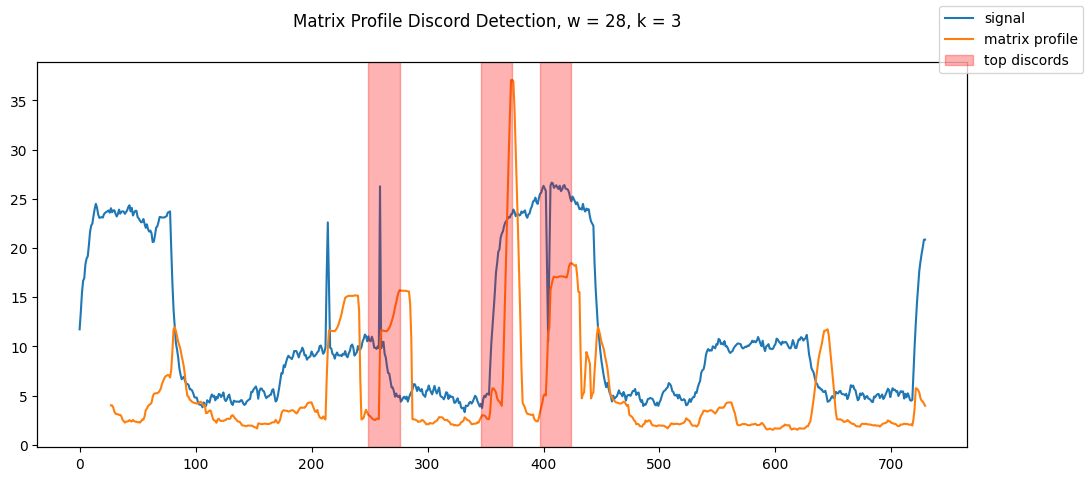

In [102]:
for w in windows:
    mat_plot = explanatory_plot(gensyn["energy"], window_experiment, w, title=f"Matrix Profile Discord Detection, w = {w}, k = 3")
    mat_plot.show()

Single point anomalies are reliably found with a small window size. When the window size increases, the large rise in energy usage is flagged as an anomoly, causing a large matrix profile value than the smallest of the true anomalies. So in general, changing the window size will cause longer duration anomalous sequences to be flagged as anomalies. I wanted to investigate if this could be mitigated by differencing the sequence.

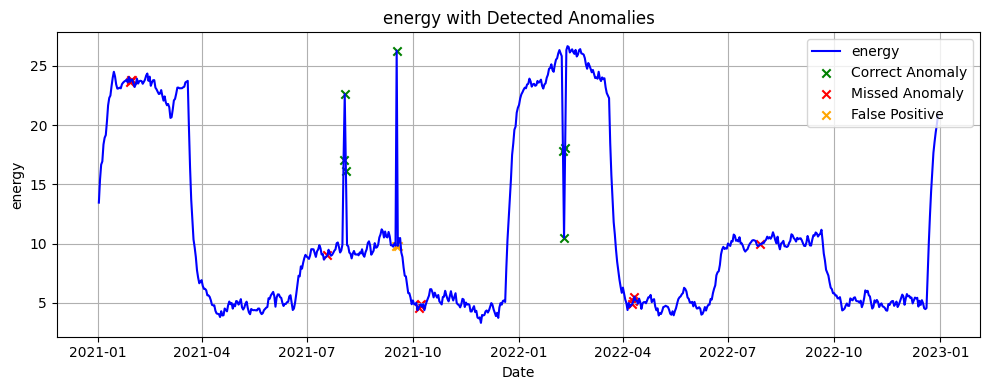

In [121]:
plot_detection(df=gensyn_copy, y_true=gensyn_copy["label"], y_pred=window_experiment[3]["mask"], start_day=1, start_year=2021, end_day=730, end_year=2023, feature="energy")

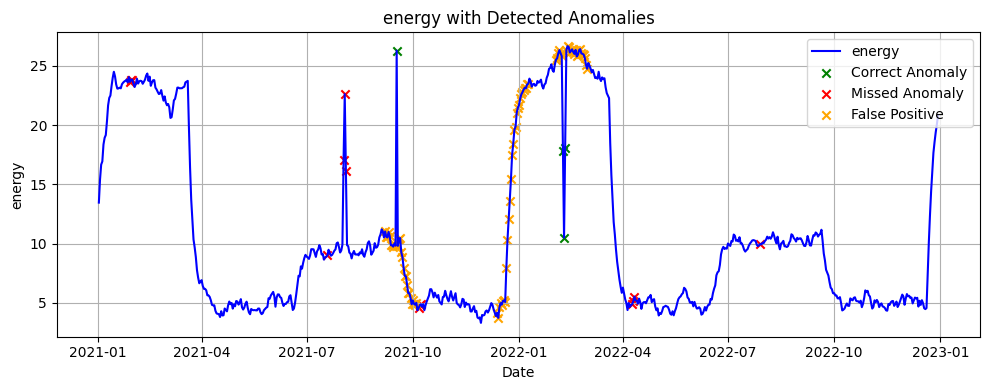

In [122]:
plot_detection(df=gensyn_copy, y_true=gensyn_copy["label"], y_pred=window_experiment[28]["mask"], start_day=1, start_year=2021, end_day=730, end_year=2023, feature="energy")

A visual understanding of the anomaly detection accuracy can be attained using the provided utility functions.

Firstly, there are more false positives with larger window lengths, as everything in the window is classed as anomalous. While it is outside the scope of this project, it might be worth investigating how the matrix profile could be used to detect anomalous sequences, and then anomalous values within could be flagged with a different method.

It seems that regardless of the window length, when not using normalisation, the matrix profile is unable to detect anomalous patterns, rather than anomalous values. When `w=3`, the only missed anomalies are anomalous patterns rather than anomalous values. When `w=28`, one spike in values is missed. This is because the increase in energy usage at the end of 2021 produces a higher matrix profile value than the first 'spike' in 2021, and the spike is missed from the top k filtering.

In [108]:
gensyn["energy_diff"] = gensyn["energy"].diff()

gensyn_copy = gensyn[1:-1] # otherwise the first value in the sequence is always anomalous

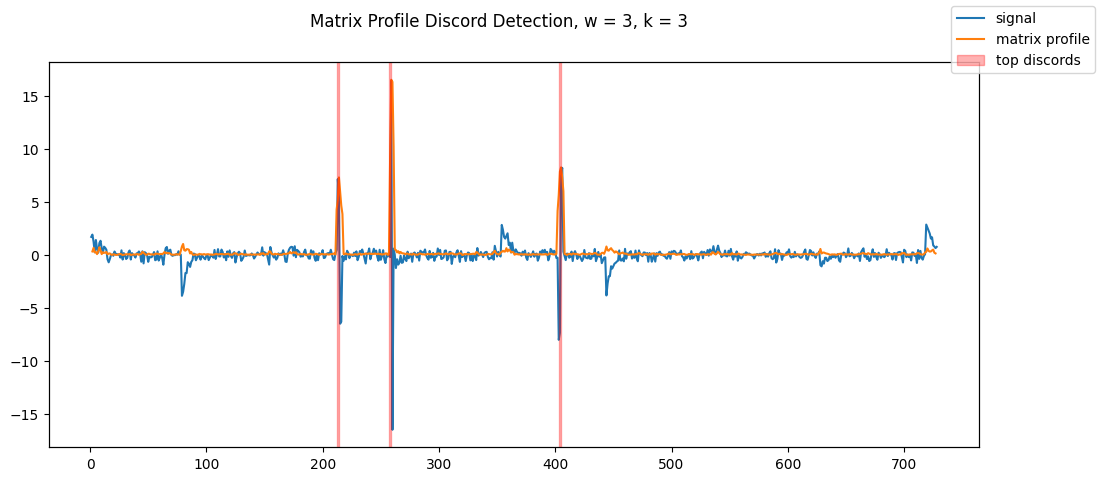

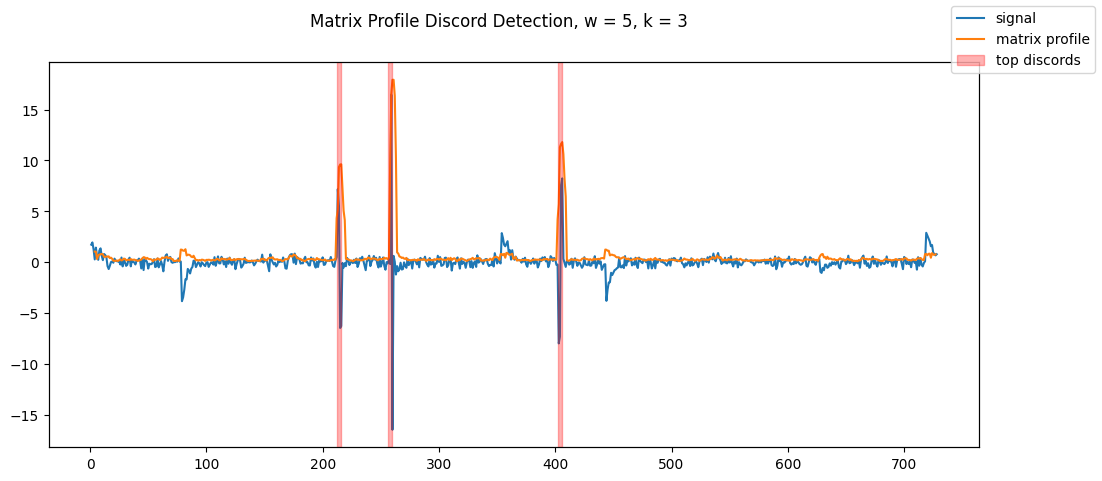

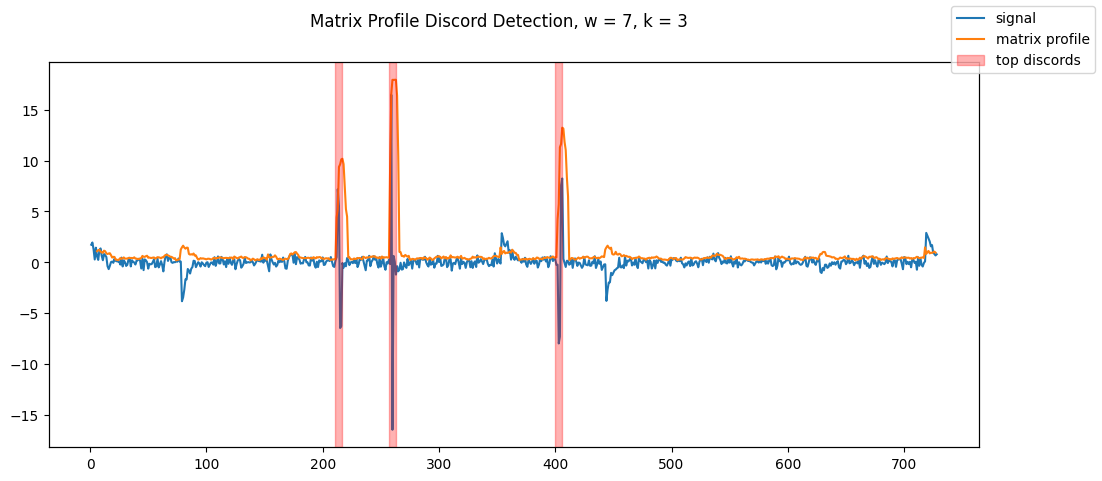

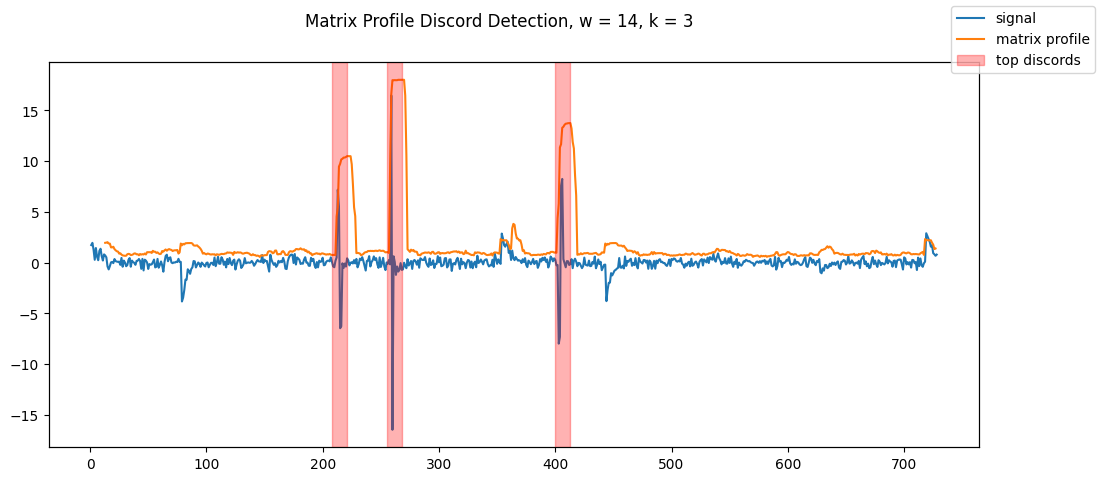

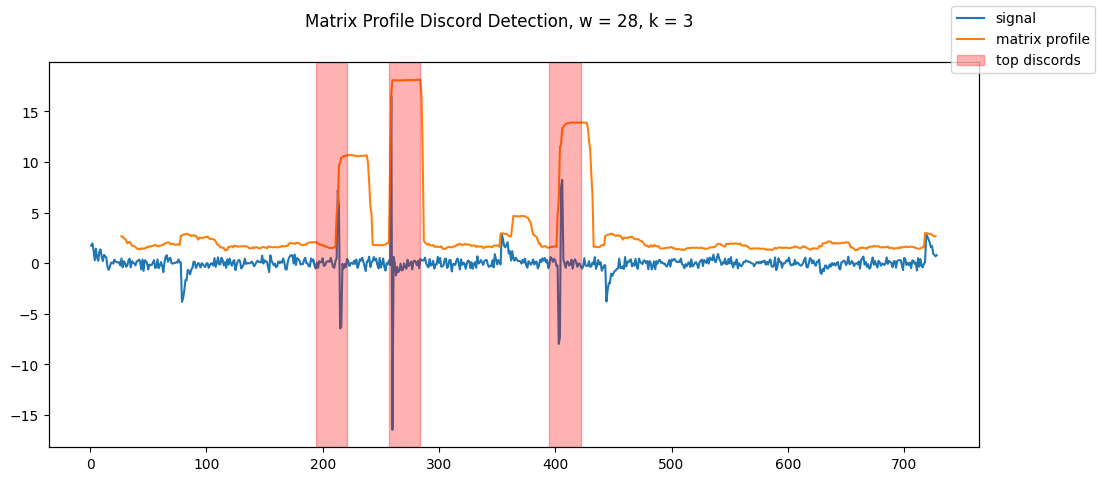

In [107]:
window_experiment_diff = find_anomalies(gensyn_copy, "energy_diff", windows, k=3, normalize=False, exclude_nearby=True, gpu=gpus)
for w in windows:
    mat_plot = explanatory_plot(gensyn_copy["energy_diff"], window_experiment_diff, w,
                                title=f"Matrix Profile Discord Detection, w = {w}, k = 3")
    mat_plot.show()

Differencing the sequence makes the single point anomalies much more prominent. These are now reliably detected regardless of the window size. This could be a useful approach to more reliably find single point anomalies.

A utility function has been provided to help evaluate the accuracy of the anomaly detection:

In [116]:
evaluate_predictions(gensyn_copy["label"], window_experiment_diff[3]["mask"])

| Model | Recall | Precision | Correct | Missed | False Positives |
|-------|--------|-----------|---------|--------|------------------|
| unnamed | 0.333 | 0.667 | 6 | 12 | 3 |


In [117]:
evaluate_predictions(gensyn_copy["label"], window_experiment_diff[5]["mask"])

| Model | Recall | Precision | Correct | Missed | False Positives |
|-------|--------|-----------|---------|--------|------------------|
| unnamed | 0.389 | 0.467 | 7 | 11 | 8 |


In [118]:
evaluate_predictions(gensyn_copy["label"], window_experiment_diff[7]["mask"])

| Model | Recall | Precision | Correct | Missed | False Positives |
|-------|--------|-----------|---------|--------|------------------|
| unnamed | 0.389 | 0.333 | 7 | 11 | 14 |


In [119]:
evaluate_predictions(gensyn_copy["label"], window_experiment_diff[14]["mask"])

| Model | Recall | Precision | Correct | Missed | False Positives |
|-------|--------|-----------|---------|--------|------------------|
| unnamed | 0.389 | 0.167 | 7 | 11 | 35 |


In [120]:
evaluate_predictions(gensyn_copy["label"], window_experiment_diff[28]["mask"])

| Model | Recall | Precision | Correct | Missed | False Positives |
|-------|--------|-----------|---------|--------|------------------|
| unnamed | 0.611 | 0.131 | 11 | 7 | 73 |


In general as the window size increases:
- `Recall` improves and `Correct` increases, and `Missed` decreases, as the larger window size captures more anomalies
- `Precision` decreases, `False Positives` increases, as the larger window size directly causes more false positives

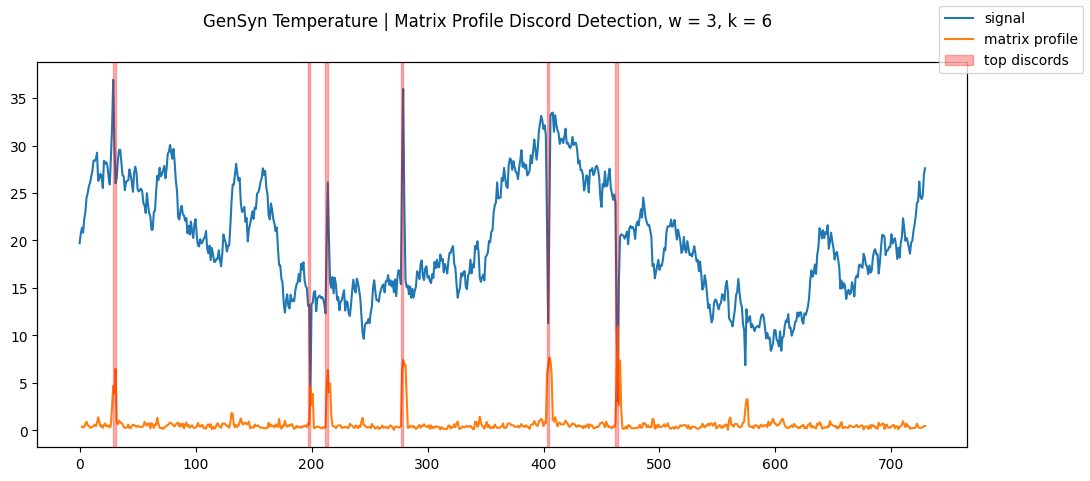

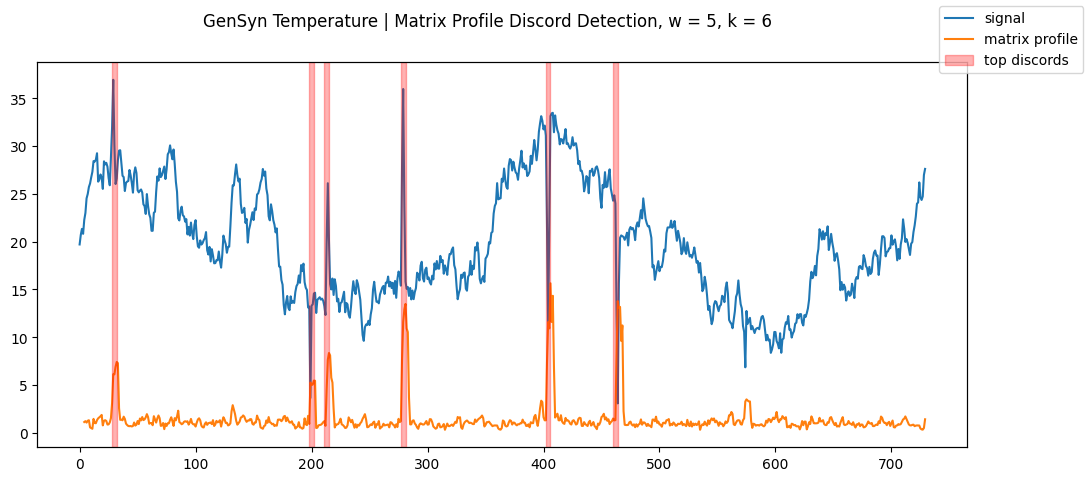

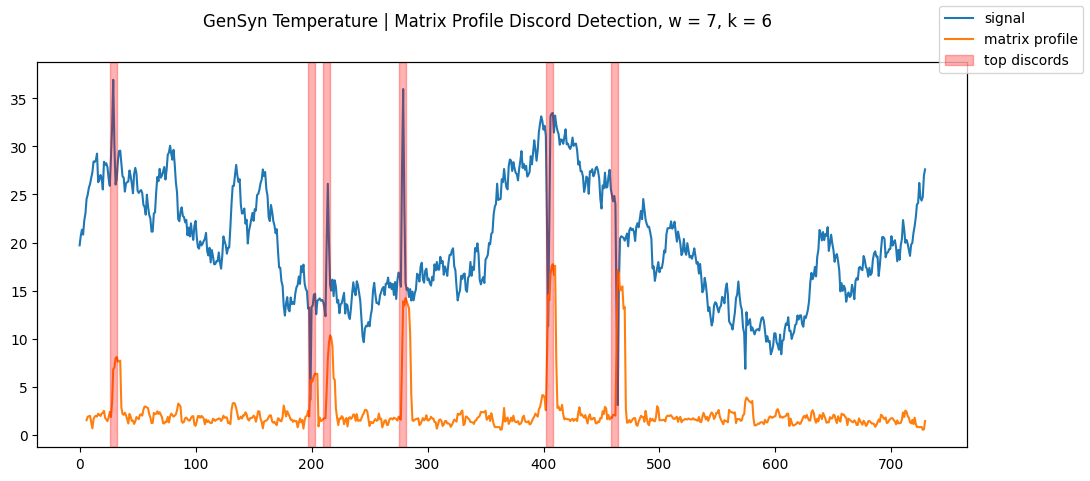

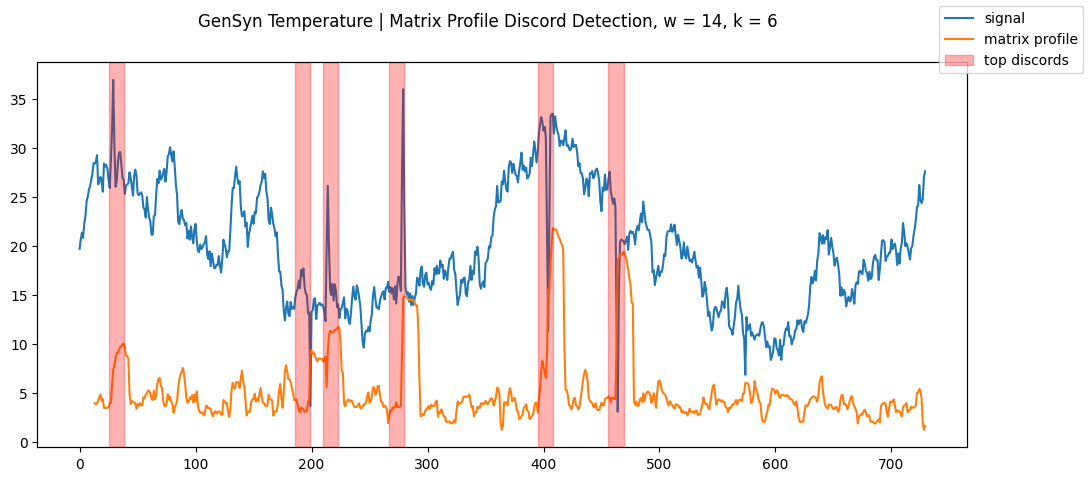

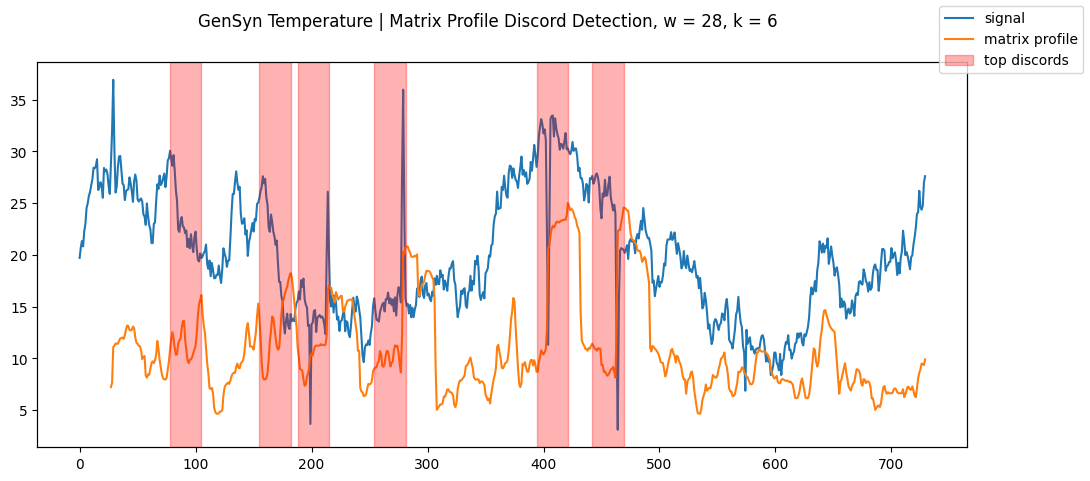

In [113]:
window_experiment_temperature = find_anomalies(gensyn, "temperature", windows, k=6, normalize=False, exclude_nearby=True, gpu=gpus)

for w in windows:
    mat_plot = explanatory_plot(gensyn["temperature"], window_experiment_temperature, w,
                                title=f"GenSyn Temperature | Matrix Profile Discord Detection, w = {w}, k = 6")
    mat_plot.show()

In [114]:
gensyn["temperature_diff"] = gensyn["temperature"].diff()

gensyn_copy = gensyn[1:-1]

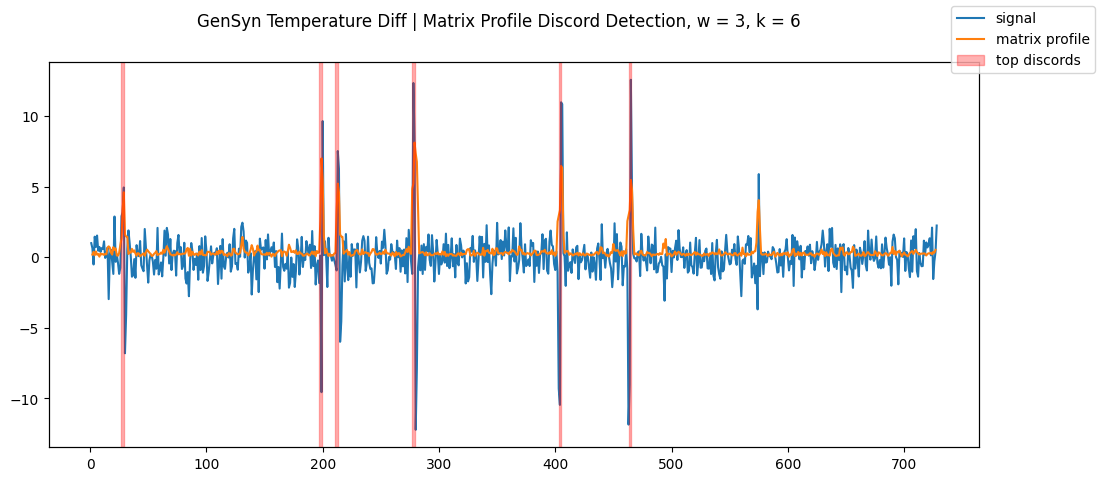

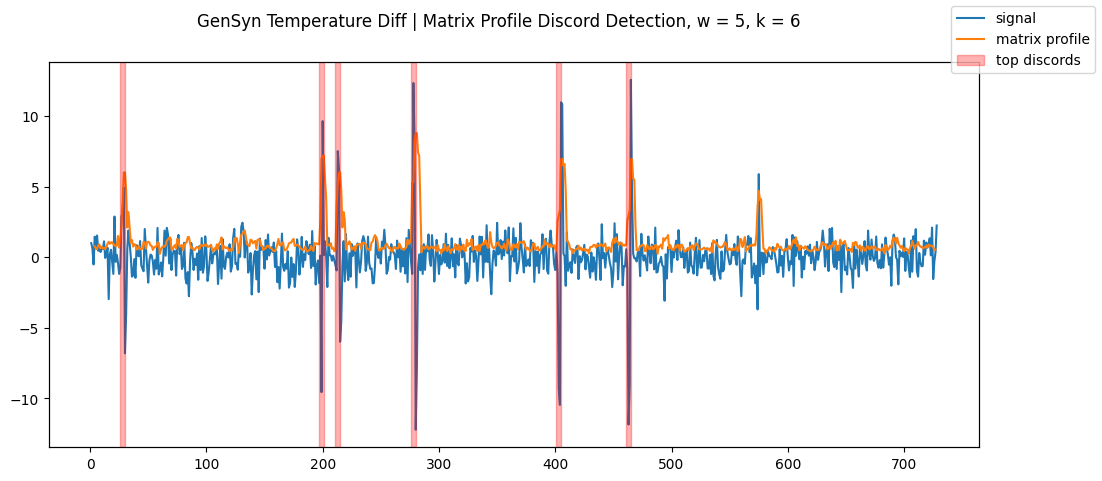

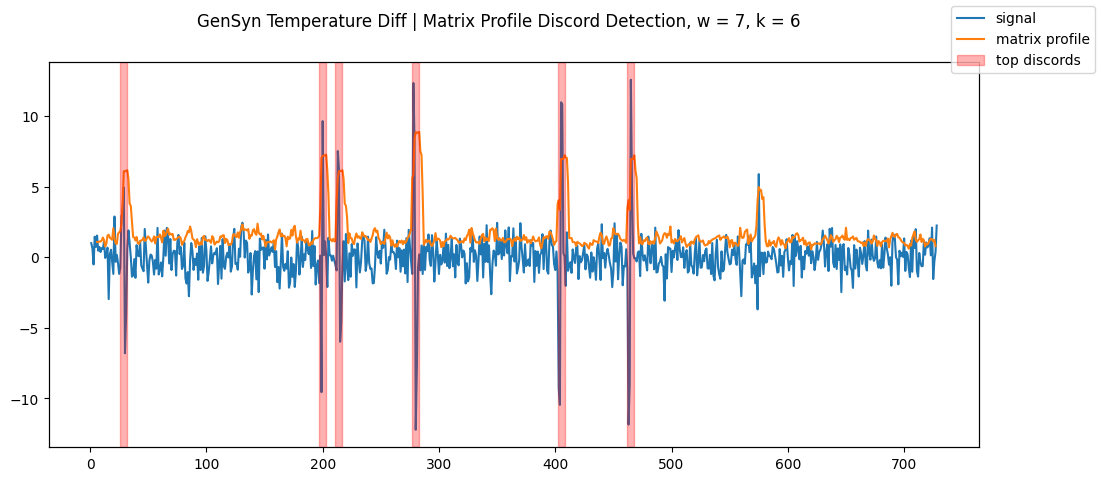

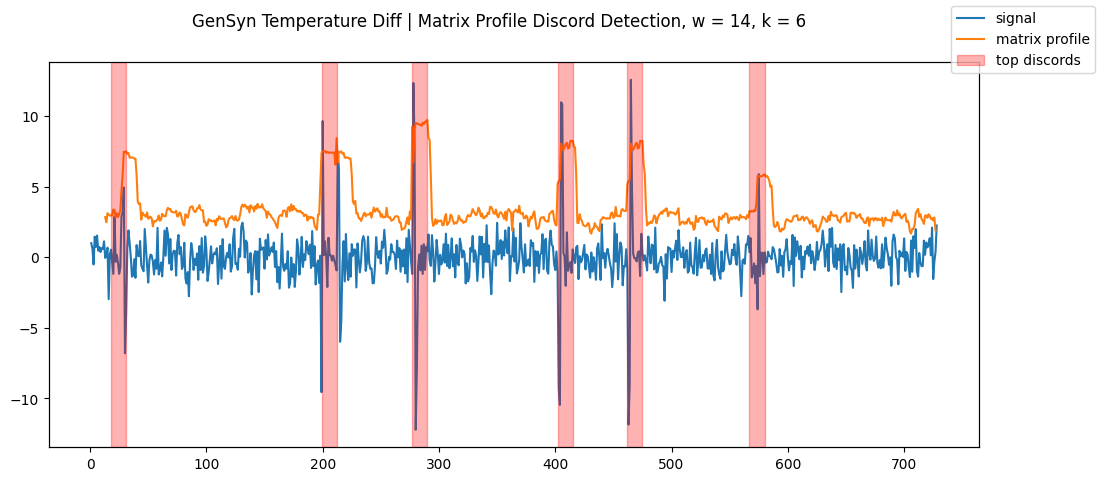

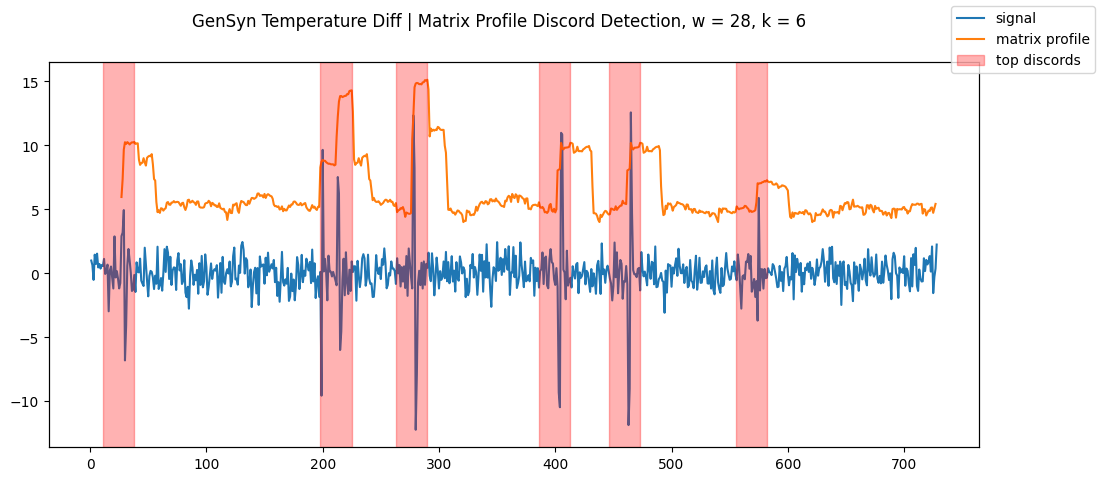

In [115]:
window_experiment_temperature = find_anomalies(gensyn_copy, "temperature_diff", windows, k=6, normalize=False, exclude_nearby=True, gpu=gpus)

for w in windows:
    mat_plot = explanatory_plot(gensyn_copy["temperature_diff"], window_experiment_temperature, w,
                                title=f"GenSyn Temperature Diff | Matrix Profile Discord Detection, w = {w}, k = 6")
    mat_plot.show()

## Assignment Questions:

**(a) Choice of window size**

*How does changing the subsequence length (e.g., 24 hours, 48 hours, 168 hours) affect which anomalies are discovered?*

Single point anomalous values are more likely to be found in a non-differenced sequence with a smaller window size. A larger window size will increase the matrix profile value for long, anomalous patterns, even if the individual values aren't global/local anomalies. This is influenced by the normalize parameter - in these experiments, normalization was disabled, as we are interested in detecting anomalous values. With normalization enabled, anomalous patterns will be found, rather than anomalous values. This was displayed by the chart `Matrix Profile Discords | k=3, z-normalised`: anomalous patterns were found, while anomalous values were ignored. In this case, I would expect the length of the sequence would change how long an anomalous sequence would have to occur for to be flagged.

**(b) Comparison across window sizes**

*Are the same anomalies detected consistently across different window sizes, or do different anomalies appear?*

In the temperature time series, the same anomalies were detected reliably.

In the energy usage dataset, the same anomalies are reliably detected, until the window size got large enough to detect the globally unique increase in temperature found as energy usage went from low to high. This caused a large increase in the non-normalised matrix profile. This is always going to be context specific. This is also only relevant because `normalize` was set to `false`. When z-normalization is set, the window length is going to have a large impact on which anomalies are detected, as the window size will affect how long anomalous sequences have to be for them to have *top k* prominance.


### Notes on implementation

Anomalies were detected with a 'top k' approach - i.e. the top `k` maxima in the matrix profile were identified as discords. In practice, this may not be appropriate, as one might not know how many discords appear in the dataset.

Inspired by STUMPY's 'ignore trivial' implementation to ignore nearby segments of the same series when computing the matrix profile, I implemented a similar algorithm for identifying discords. Once a discord is identified, matrix profile values from `w` indices before and after the discord are marked as ineligible for discords to be found. I decided to implement this because I noticed that when the matrix profile value gets high (potentially due to one anomalous point) it tends to stay high while the anomalous point is within `w` indices. This means that discords are output as non-overlapping regions.